# Creating Videos (Ring Resonator)

This notebook demonstrates the live animation feature in Jupyter notebooks. When running `sim.run(animate_live="Ez")`, the simulation animates directly in the cell output, and after completion, you can replay the animation interactively.

**Author:** Quentin Wach
**Published:** 2025-01-15
**Updated:** 2025-05-01
**Tags:** Simulation, Visualization

![preview](attachment:imgs/animation_demo.png)

In [1]:
from beamz import *
import numpy as np

## Simulation Parameters

We simulate a Si3N4 ring resonator coupled to a straight waveguide at 1550 nm.

In [2]:
# Wavelength and simulation time
WL = 1.55 * um
TIME = 120 * WL / LIGHT_SPEED
# Domain size
X, Y = 20 * um, 19 * um
# Geometry parameters
RING_RADIUS = 6 * um
WG_WIDTH = 0.5 * um
# Materials: Si3N4 core, SiO2 cladding
N_CORE, N_CLAD = 2.04, 1.444
# Calculate optimal grid spacing and time step
DX, DT = calc_optimal_fdtd_params(WL, max(N_CORE, N_CLAD), dims=2, points_per_wavelength=9)

print(f"Grid spacing: {DX*1e9:.1f} nm")
print(f"Time step: {DT*1e15:.2f} fs")
print(f"Total steps: {int(TIME/DT)}")

Grid spacing: 84.4 nm
Time step: 0.20 fs
Total steps: 3118


## Create the Design

A straight waveguide with a ring resonator coupled above it.

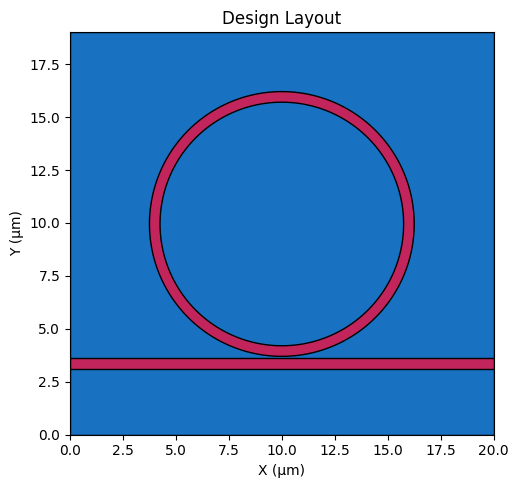

In [3]:
# Create design with SiO2 cladding
design = Design(width=X, height=Y, material=Material(N_CLAD**2))
# Add straight waveguide
design += Rectangle(position=(0, WL * 2), width=X, height=WG_WIDTH, material=Material(N_CORE**2))
# Add ring resonator
ring_center_y = WL * 2 + WG_WIDTH + RING_RADIUS + WG_WIDTH / 2 + 0.2 * WG_WIDTH
design += Ring(
    position=(X / 2, ring_center_y),
    inner_radius=RING_RADIUS - WG_WIDTH / 2,
    outer_radius=RING_RADIUS + WG_WIDTH / 2,
    material=Material(N_CORE**2)
)

# Show the design
design.show()

## Define the Source

A TM-polarized mode source injects light into the waveguide from the left.

In [4]:
# Rasterize the design
grid = design.rasterize(resolution=DX)

# Create time array
time_steps = np.arange(0, TIME, DT)

# Create a ramped cosine signal
signal = ramped_cosine(
    time_steps, 
    amplitude=1.0, 
    frequency=LIGHT_SPEED / WL, 
    phase=0,
    ramp_duration=WL * 6 / LIGHT_SPEED, 
    t_max=TIME / 2.5
)

# Create mode source
source = ModeSource(
    grid=grid,
    center=(WL * 2, WL * 2 + WG_WIDTH / 2),
    width=WG_WIDTH * 1.2,
    wavelength=WL,
    pol="tm",
    signal=signal,
    direction="+x",
)

● Auto-selecting 2D meshing for effectively 2D design (depth=0)

Output()

## Run the Simulation with Live Animation

The animation will display **live** in this cell as the simulation runs. After completion, the result contains an `animation` object for replay.

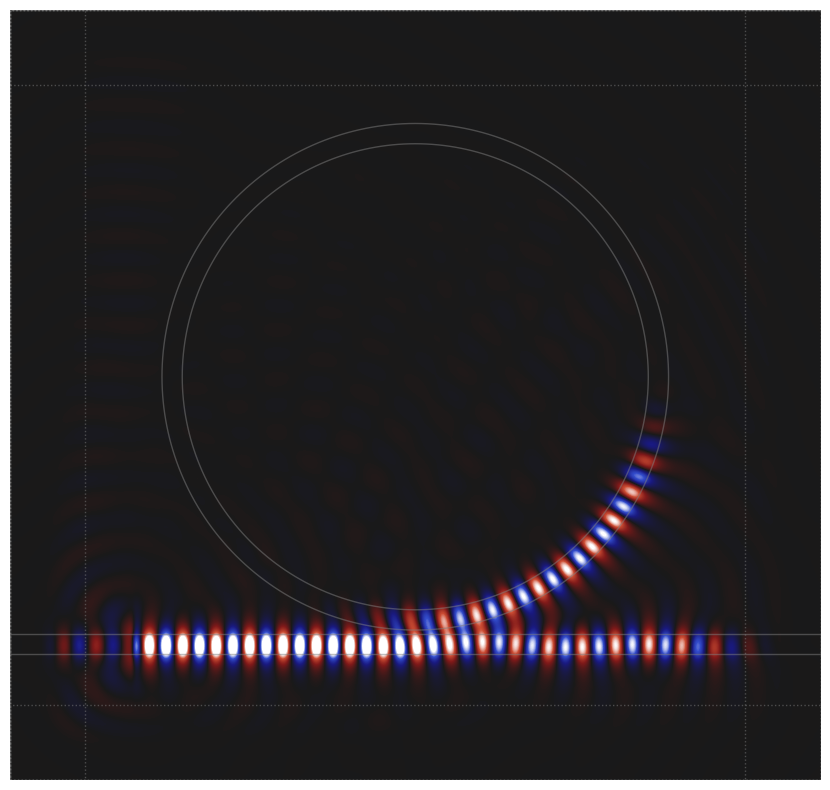

In [ ]:
# Create simulation
sim = Simulation(
    design=design,
    devices=[source],
    boundaries=[PML(edges='all', thickness=1.2 * WL)],
    time=time_steps,
    resolution=DX
)

# Run with live animation
result = sim.run(
    animate_live="Ez",
    animation_interval=5,
    axis_scale=[-0.9e-4, 0.9e-4],
    cmap="twilight_zero",
    clean_visualization=True
)

print("Simulation complete!")
print(f"Frames stored: {len(result['animation'].frames)}")

## Replay as MP4 Video

Use `get_video()` to create an MP4 video file and play it directly in the notebook. This is more efficient than HTML5 for larger animations. (Alternatively, you can use `get_animation()` to see the raw frames.)

In [ ]:
result['animation'].get_video(filename='resring.mp4', fps=30) # ideal for large animations
#result['animation'].get_animation(fps=40) # better for smaller animations and frame-by-frame control

Rendering 311 frames to resring.mp4...
Video saved: resring.mp4 (2.0 MB)
